<h1 id="display">The display package</h1>
<p>
The package `github.com/gopherdata/gophernotes` is automatically imported with the name `display`.
</p><p>
It provides several functions that convert `string`, `[]byte`, `image.Image`, `io.Reader` or `io.WriterTo` containing images, HTML, Markdown, LaTeX etc. to `display.Data`, which is shown graphically if returned at prompt. Example:
<p/>

In [1]:
display.HTML(`<h1 style="color:green;">Hello, World</h1>`)

<h1 style="color:green;">Hello, World</h1>

<h1>Display function</h1>
<p>
Sometimes, returning `display.Data` at prompt is not handy - for example from deep inside functions or blocks, or because you want to display multiple data at once.
</p><p>
In such cases, you can call the function `Display(display.Data) error` to display the data immediately:
</p>

In [2]:
{
    Display(display.Markdown("* hello from markdown"))
    Display(display.Math(`e^{i\pi}+1=0`))
}

* hello from markdown

e^{i\pi}+1=0

<h1 id="images">Images</h1>
<p>
The functions to display JPEG, PNG or SVG images and `image.Image` are:
</p>

In [3]:
import "image"
// in package "display"
func JPEG([]byte) error
func PNG([]byte) error
func SVG(string) error
func Image(image.Image) error

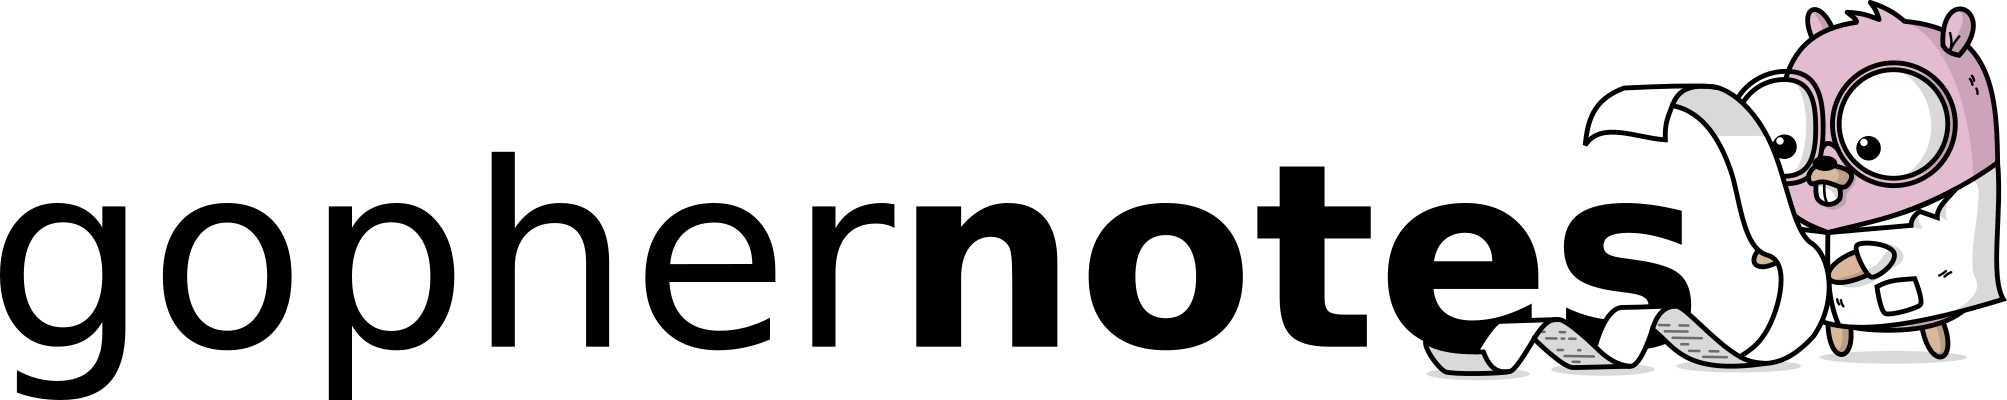

In [4]:
// Example: download and display a PNG
import (
    "net/http"
    "io/ioutil"
)
resp, err := http.Get("https://github.com/gopherdata/gophernotes/raw/master/files/gophernotes-logo.png")
bytes, err := ioutil.ReadAll(resp.Body)
resp.Body.Close()
display.PNG(bytes)

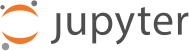

In [5]:
// download and display an SVG
resp, err := http.Get("http://jupyter.org/assets/nav_logo.svg")
bytes, err := ioutil.ReadAll(resp.Body)
resp.Body.Close()
display.SVG(string(bytes))

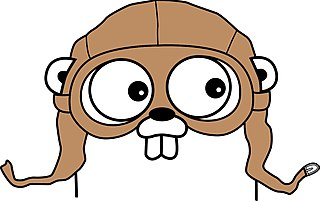

In [7]:
// download and display a JPEG
resp, err := http.Get("https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Go_gopher_app_engine_color.jpg/320px-Go_gopher_app_engine_color.jpg")
bytes, err := ioutil.ReadAll(resp.Body)
resp.Body.Close()
display.JPEG(bytes)

Or, if you prefer to use `image.Image`:

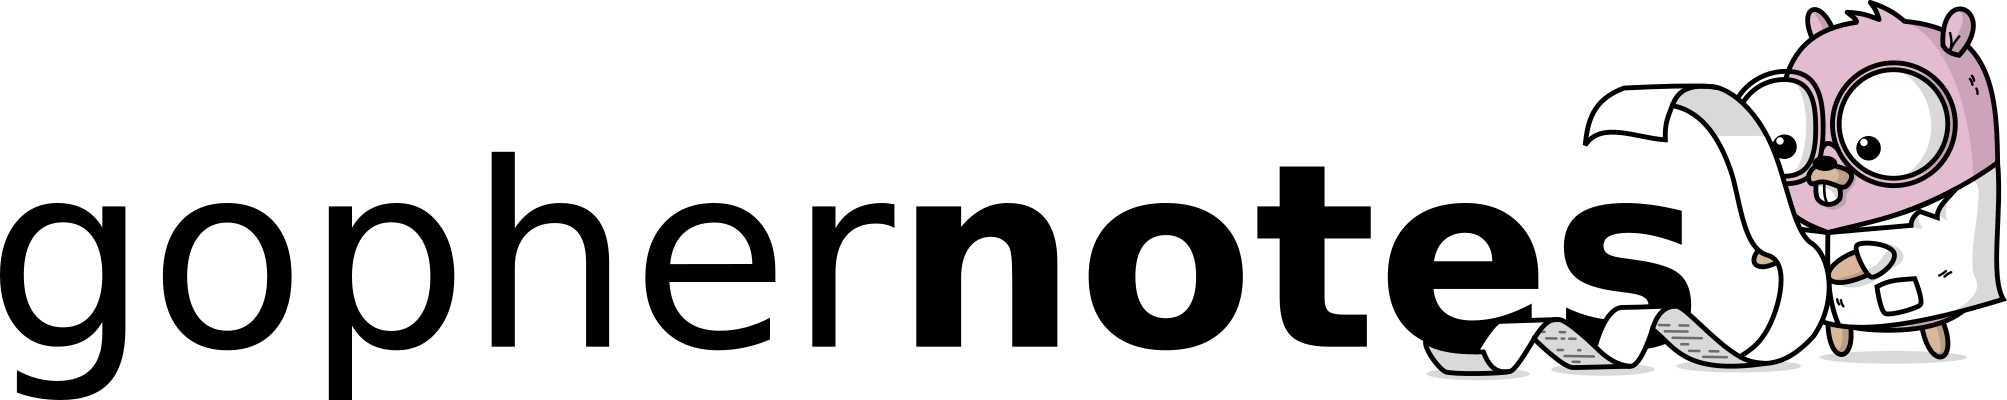

In [8]:
import "image"
resp, err := http.Get("https://github.com/gopherdata/gophernotes/raw/master/files/gophernotes-logo.png")
img, ext, err := image.Decode(resp.Body)
resp.Body.Close()
display.Image(img)

<h1 id="plotting">Plotting with gonum/plot</h1>

Using the functions above, you can also display plots with `gonum/plot`.

This requires importing third-party packages, which is currently only supported on Linux and Mac OS X.

For example:

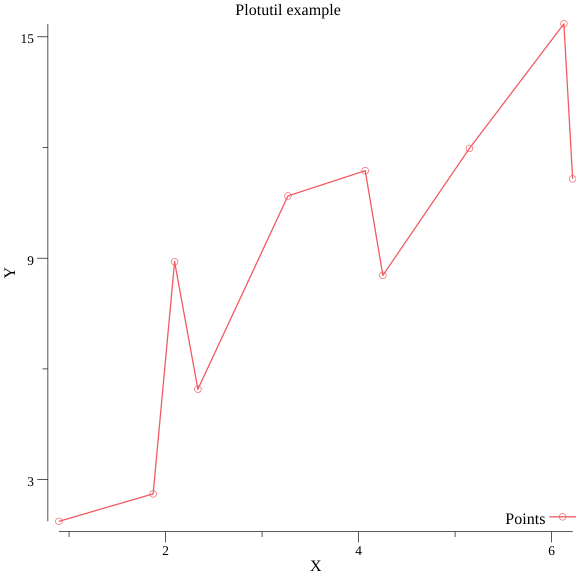

In [14]:
import (
    "math/rand"
    "bytes"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg"
)

func displayPlot(p *plot.Plot) {
    var buf bytes.Buffer
    c, err := p.WriterTo(6*vg.Inch, 6*vg.Inch, "png")
    if err != nil {
        panic(err)
    }
    if _, err := c.WriteTo(&buf); err != nil {
        panic(err)
    }
    Display(display.PNG(buf.Bytes()))
}

func randomPoints(n int) plotter.XYs {
    pts := make(plotter.XYs, n)
    for i := range pts {
        if i == 0 {
            pts[i].X = rand.Float64()
        } else {
            pts[i].X = pts[i-1].X + rand.Float64()
        }
        pts[i].Y = pts[i].X + 10*rand.Float64()
    }
    return pts
}

p, err := plot.New()

p.Title.Text = "Plotutil example"
p.X.Label.Text = "X"
p.Y.Label.Text = "Y"

err = plotutil.AddLinePoints(p, "Points", randomPoints(10))

displayPlot(p)

<h1 id="reference">Reference</h1>
<p>The list of available constants, types, and functions in package <code>display</code> is:</p>

In [8]:
// in package "display"

const (
	MIMETypeHTML       = "text/html"
	MIMETypeJavaScript = "application/javascript"
	MIMETypeJPEG       = "image/jpeg"
	MIMETypeJSON       = "application/json"
	MIMETypeLatex      = "text/latex"
	MIMETypeMarkdown   = "text/markdown"
	MIMETypePNG        = "image/png"
	MIMETypePDF        = "application/pdf"
	MIMETypeSVG        = "image/svg+xml"
	MIMETypeText       = "text/plain"
)

// MIMEMap holds data that can be presented in multiple formats. The keys are MIME types
// and the values are the data formatted with respect to its MIME type.
// If a map does not contain a "text/plain" key with a string value,
// it will be set automatically.
type MIMEMap = map[string]interface{}

// Data is the exact structure sent to the front-end (Jupyter...) for displaying.
// It contains all the information needed to graphically show a value.
type Data = struct {
	Data      MIMEMap
	Metadata  MIMEMap
	Transient MIMEMap
}

// the functions Any() and Auto() accept string, []byte, image.Image, io.Reader, io.WriterTo
func Any(mimeType string, data interface{}) Data // if mimeType is empty, autodetects it
func Auto(data         interface{}) Data // autodetects mimeType

func HTML(html         string) Data
func JSON(json         map[string]interface{}) Data
func JavaScript(javascript string) Data
func JPEG(jpeg         []byte) Data
func Image(img         image.Image) Data
func Latex(latex       string) Data
func Markdown(markdown string) Data
func Math(latex        string) Data // LaTeX formula, without starting and ending '$$' 
func PDF(pdf           []byte) Data
func PNG(png           []byte) Data
func SVG(svg           string) Data

func MakeData(mimeType string, data interface{}) Data
func MakeData3(mimeType string, plaintext string, data interface{}) Data
func MIME(data, metadata MIMEMap) Data

<h1 id="advanced">Advanced usage</h1>
<p>gophernotes also provides the following interfaces, mainly targeted at authors of Go libraries.</p>
<p>If the only non-nil value returned at prompt has type <code>Data</code> or implements one of these interfaces, it will be automatically rendered graphically<p>


In [9]:
/**
 * general interface, allows libraries to fully specify
 * how their data is displayed by Jupyter.
 * Supports multiple MIME formats.
 *
 * Note that Data defined above is an alias:
 * libraries can implement Renderer without importing gophernotes
 */
type Renderer = interface {
	Render() Data
}

/**
 * simplified interface, allows libraries to specify
 * how their data is displayed by Jupyter.
 * Supports multiple MIME formats.
 *
 * Note that MIMEMap defined above is an alias:
 * libraries can implement SimpleRenderer without importing gophernotes
 */
type SimpleRenderer = interface {
	SimpleRender() MIMEMap
}

/**
 * specialized interfaces, each is dedicated to a specific MIME type.
 *
 * They are type aliases to emphasize that method signatures
 * are the only important thing, not the interface names.
 * Thus libraries can implement them without importing gophernotes
 */
type HTMLer = interface {
	HTML() string
}
type JavaScripter = interface {
	JavaScript() string
}
type JPEGer = interface {
	JPEG() []byte
}
type JSONer = interface {
	JSON() map[string]interface{}
}
type Latexer = interface {
	Latex() string
}
type Markdowner = interface {
	Markdown() string
}
type PNGer = interface {
	PNG() []byte
}
type PDFer = interface {
	PDF() []byte
}
type SVGer = interface {
	SVG() string
}

<p>If you want, interpreted code can implement the above interfaces too:<p>

In [10]:
// implement HTMLer
type H struct {
}
func (h H) HTML() string {
    return `<h2 style="color:blue;">Hello again, world!</h2>`
}
H{}

Hello again, world!

In [11]:
// implement SimpleRenderer
type S struct {
}
func (s S) SimpleRender() display.MIMEMap {
    return display.MIMEMap{
        // Maxwell equations, in covariant formulation
        display.MIMETypeLatex: `$\partial_\alpha F^{\alpha\beta} = \mu_0 J^\beta$`,
    }
}
S{}

<p>Or also, if you want to fully control how your data should be rendered:</p>

In [12]:
// implement Renderer
type R struct {
}
func (r R) Render() display.Data {
    return display.Data{
        Data: display.MIMEMap{
            // Einstein general relativity equations
            display.MIMETypeLatex: `$G_{\mu\nu} = \frac{8 \pi G}{c^4} T_{\mu\nu}$`,
        },
    }
}
R{}